In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load modal 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Load evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load train test split

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [46]:
df=pd.read_csv('../data/olist_customers_dataset.csv')


In [47]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numerical_imputer = SimpleImputer(strategy='most_frequent')
cateogrical_imputer = SimpleImputer(strategy='constant', fill_value='No reviews')


numerical_features=["product_weight_g","product_length_cm","product_height_cm","product_width_cm"]
categorical_features=["review_comment_message"]

imputer=ColumnTransformer([
    ('numerical_imputer',numerical_imputer,numerical_features),
    ('categorical_imputer',cateogrical_imputer,categorical_features)
])

imputer.fit(df[numerical_features+categorical_features])
#impute the missing values
df[numerical_features+categorical_features]=imputer.transform(df[numerical_features+categorical_features])

In [48]:
#remove unnecessary columns
df= df.drop(
                [
                    "order_approved_at",
                    "order_delivered_carrier_date",
                    "order_delivered_customer_date",
                    "order_estimated_delivery_date",
                    "order_purchase_timestamp",
                      "customer_zip_code_prefix",
                    "order_item_id",
                ],
                axis=1,
            )



In [49]:
df=df.select_dtypes(include=[np.number])
df.head()

,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,review_score
0,1,1,18.12,29.99,8.72,40.0,268.0,4.0,4
1,3,1,2.00,29.99,8.72,40.0,268.0,4.0,4
2,2,1,18.59,29.99,8.72,40.0,268.0,4.0,4
3,1,3,37.77,29.99,7.78,40.0,268.0,4.0,4
4,1,1,37.77,29.99,7.78,40.0,268.0,4.0,5


In [50]:
df.isna().sum()

payment_sequential            0
payment_installments          0
payment_value                 0
price                         0
freight_value                 0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
review_score                  0
dtype: int64

## Model building

In [51]:

X=df.drop("review_score",axis=1)
y=df["review_score"]

#split the data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)



In [52]:
def model_scores(models):
    np.random.seed(42)
    model_scores={}

    for label,model in models.items():
        model.fit(x_train,y_train)
        model_scores[label]=model.score(x_test,y_test)
       
    
    return model_scores


models={'Logistic Regression':LogisticRegression(),
        "Random Forest":RandomForestRegressor(),
        "Linear Regression":LinearRegression(),
        "XGBoost":xgb.XGBRegressor()}
model_scores=model_scores(models)




/Users/magesh/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
model_scores

{'Logistic Regression': 0.5649165297119626,
 'Random Forest': 0.16026777691801553,
 'Linear Regression': 0.017827455900480516,
 'XGBoost': 0.09483676581993405}

In [60]:
# Hyperparameter tuning

# RandomForestClassifier

rf_grid = {
    "n_estimators": np.arange(10,1000,50),
    "max_depth": [None,3,5,10],
    "min_samples_split": np.arange(2,20,2),

    "min_samples_leaf": np.arange(1,20,2),

    "max_features": [0.5,1,"sqrt","auto"],

}

# RandomizedSearchCV

rs_model = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_model.fit(x_train,y_train)

print("Best set of hyperparameters: ", rs_model.best_params_)
print("Best score: ", rs_model.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[18:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[18:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[18:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[18:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[18:09:50] WARNING: /Users/runner/

KeyboardInterrupt: 

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix

def model_confusstion_matrix(model,y_test,x_test,model_name):
    y_preds=model.predict(x_test)
    y_preds = np.round(y_preds)
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_preds)
    print("Accuracy:", accuracy * 100, "%")

    conf=confusion_matrix(y_test,y_preds)
    sns.heatmap(conf,annot=True,fmt='d',cbar=False,cmap='YlGnBu');
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label');
    plt.title('Confusion Matrix of'+" "+model_name);
    

In [67]:

random_model=RandomForestRegressor(
    n_estimators=360,
    min_samples_split=8,
    min_samples_leaf=5,
    max_features=0.5,
    max_depth=10)

random_model.fit(x_train,y_train)

random_model.score(x_test,y_test)

0.07158101442079134

In [91]:
log_model=LogisticRegression()
log_model.fit(x_train,y_train)
log_model.score(x_test,y_test)


/Users/magesh/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5649165297119626

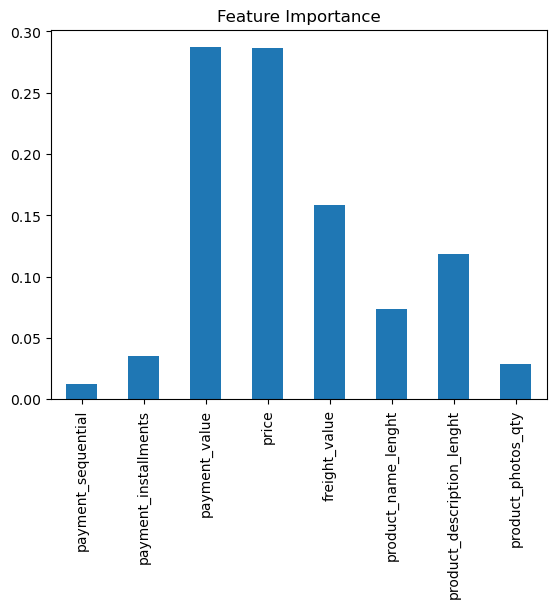

In [64]:
# Feature Importance

model.feature_importances_

feature_dict=dict(zip(x_train.columns,list(model.feature_importances_)))



feature_df=pd.DataFrame(feature_dict,index=[0])

feature_df.T.plot(kind='bar',legend=False,title='Feature Importance');